# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [ ]:
os.chdir('20200202_6W-LaC024B/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [ ]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [7]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [8]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [9]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [10]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [11]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
723,A2,1154,745,1401.718425,1496.485511,299,2888,740.136752,740.358974,0.108499,79.998606,0.384140
551,A3,318,576,1462.962712,1473.007910,82,2202,739.293103,740.172414,0.112572,18.416257,0.727619
781,A2,190,808,1466.851127,1519.756821,52,2850,739.774510,740.803922,0.179642,41.874786,0.834947
742,B2,1015,771,1427.220930,1469.298837,271,2881,739.151786,739.803571,0.038220,53.852995,0.870662
645,B1,475,672,1471.515302,1508.106762,123,2385,739.930233,740.918605,0.465345,29.359498,0.921250


# add mapping info

In [12]:
df_cells = pd.read_hdf('cells.hdf')

In [13]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,17,166,B3,0.950080,0.023278,0.751504,0.967865,0.704654,0.522004,1.000000,...,1,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,22,166,B3,0.982936,0.187750,1.000000,0.673755,0.824502,1.000000,0.764186,...,2,NaN,0.0,2,ATAGCAGAGCACCAGAACTG,RFT1,essentials_11L2,NaN,NaN,NaN
2,27,166,B3,1.000000,1.000000,1.000000,0.881135,0.573409,1.000000,1.000000,...,4,NaN,0.0,4,ACTTCTCCGAGAACTTGATG,EFNA3,essentials_11L2,NaN,NaN,NaN
3,29,166,B3,0.753920,0.302495,1.000000,1.000000,0.888345,0.522458,0.285893,...,2,NaN,0.0,2,ATCAGATGGGCTCCGACCCA,MRTO4,essentials_11L2,NaN,NaN,NaN
4,30,166,B3,0.352305,0.148952,0.263583,0.332182,0.050855,0.473346,0.021817,...,2,AAAGTACAGTA,1.0,3,ATAGCAGAGCACCAGAACTG,RFT1,essentials_11L2,NaN,NaN,NaN


In [14]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [15]:
df_cells.mapped_single_gene.value_counts()

True     5844363
False    2471021
Name: mapped_single_gene, dtype: int64

In [16]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [17]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
6,B1,498,618,1134.135135,53.722187,134,52,16.939394,992.131313,1.640599,1467.614017,765.758995,AAGATCACGTGGTATCGCAA,BCAM,essentials_11L2,True
5,B1,498,608,1113.646172,93.104882,134,38,11.198113,1002.245283,1.300477,1434.466170,774.548113,TACGGGTGTCAAATATGGCT,SPRYD4,essentials_11L2,True
9,B1,498,621,1144.923333,288.343333,134,56,18.818182,1050.646465,1.441331,1237.869938,785.241645,GCACCACAGGCACATAACCA,RNF168,essentials_11L2,True
7,B1,498,620,1140.492647,842.407240,134,53,16.520000,1190.120000,1.536093,722.350172,852.074718,CTGCGCACCAATCACCAGGT,TRAPPC6A,essentials_11L2,True
8,B1,498,622,1147.377477,969.335135,134,54,18.063694,1221.929936,1.776696,609.439371,868.014109,GCATCGACGGATCCATACGG,ZNF22,essentials_11L2,True
4,B1,498,604,1103.959442,198.920152,134,32,8.494845,1028.329897,1.577750,1335.129985,786.278526,NaN,NaN,NaN,NaN
2,B1,498,595,1081.049536,264.618576,134,19,3.388889,1045.155556,1.090426,1279.184693,797.317905,NaN,NaN,NaN,NaN
3,B1,498,599,1089.423077,384.366005,134,25,4.923810,1074.580952,1.422516,1163.169886,807.639412,NaN,NaN,NaN,NaN
0,B1,498,592,1076.086154,873.061538,134,15,2.602740,1198.493151,1.300549,729.054656,868.314856,NaN,NaN,NaN,NaN
1,B1,498,593,1076.792391,1184.699457,134,17,2.333333,1276.636364,1.735300,499.778738,912.211981,NaN,NaN,NaN,NaN


# add phenotype min info

In [18]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [19]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [21]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [23]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

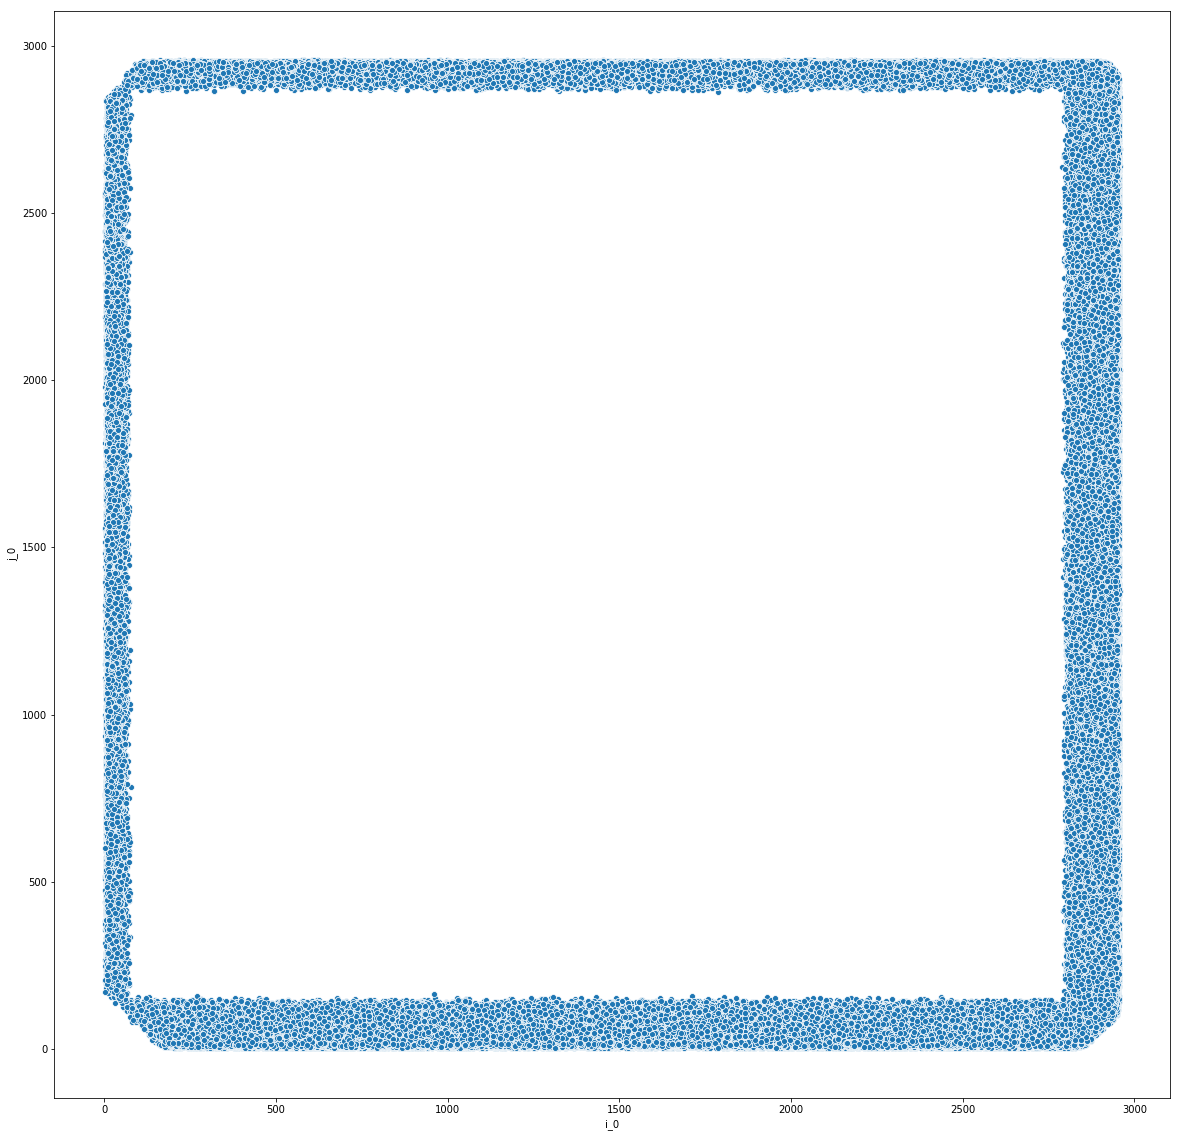

In [24]:
# visualize cells overlapping channel alignment edges
# (only relevant if phenotype channels are acquired separately)
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
                      [['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [33]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

1    7340040
2    2092062
3      22044
4        847
Name: cell_0, dtype: int64

In [34]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6841833
2    2136531
3      85243
4      55765
Name: cell_1, dtype: int64

In [36]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

9119372

In [35]:
df_merged.pipe(len)

11593684

In [37]:
# remove cells with phenotype channel min ==0
df_merged_ph = (df_merged
             .query('channels_min>0')
            )

In [38]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

9086225

In [69]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    4727830
2    1378649
3      50406
4      38094
Name: cell_1, dtype: int64

In [39]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [40]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5627544
2    1527320
3      55627
4      36185
Name: cell_1, dtype: int64

In [41]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [42]:
df_merged_filt_filt.pipe(len)

7246676

In [43]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

4452714

In [ ]:
df_merged.to_hdf('merge.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.hdf', 'x', mode='w')

# check cell matching rate

In [48]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [49]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [50]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [51]:
# before deduping
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 90.74585071174596%
For well A2, cell matching rate is 90.37514052942855%
For well A3, cell matching rate is 90.61035612717843%
For well B1, cell matching rate is 90.59275414368908%
For well B2, cell matching rate is 90.5516683630901%
For well B3, cell matching rate is 90.90505620451427%


In [52]:
del df_sbs_matching

In [53]:
del df_sbs_info

In [54]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [55]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [56]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [57]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 93.91003865526531%
For well A2, cell matching rate is 93.49577907547497%
For well A3, cell matching rate is 93.26964373260294%
For well B1, cell matching rate is 94.25099112183844%
For well B2, cell matching rate is 94.34845306822845%
For well B3, cell matching rate is 94.15653200649616%
